In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from datetime import datetime
pd.set_option('display.max_columns', 100)


In [29]:
df = pd.read_excel('Nigerian E-Commerce Dataset.xlsx')

print("Shape:", df.shape)
df.head(10)


Shape: (3928, 16)


,Order ID,Branch Location,Branch Name,Business Name,Is Deleted,Item ID,Item Name,Item Price,Order Item Number,Item Status,Packed Quantity,Quantity,Total Price,Order Date,Order Region,Order Local Area
0,4672,Lagos,Generic Store,Generic Stores,False,60a7b0242498ec1dd380508c,Golden Penny Spaghetti - 500g,4950.00,MLPLOCN1FAHUIYK50S0W9YUQ,Cancelled,1,1,4950.00,2021-05-31,Lagos,Ifako-Ijaye
1,4672,Lagos,Multipro Consumer Product Limited,MUL,False,6076c792a6000742949a819c,DANO COOLCOW SACHET - 12X380g,3392.75,ML1DN3SZT8R02DKKNKBLXDXA,Cancelled,2,2,6785.50,2021-05-31,Lagos,Ifako-Ijaye
2,4671,Lagos,Multipro Consumer Product Limited,MUL,False,6076c792a6000742949a819c,DANO COOLCOW SACHET - 12X380g,3392.75,ML2UMJU6I2P0O958PKZ9AMDQ,Cancelled,1,1,3392.75,2021-05-31,Lagos,Ifako-Ijaye
3,4670,Lagos,TDILIFE,TDILIFE,False,608045d069c51b4e80e70343,HOLLANDIA EVAP MILK FULL CREAM 60g X 48,3370.00,MLDFDZKVPFV0SHDGGA2KFNRG,Delivered,1,1,3370.00,2021-05-31,Lagos,Ifako-Ijaye
4,4670,Lagos,TDILIFE,TDILIFE,False,608042a469c51b4e80e702f7,HOLLANDIA EVAP MILK FULL CREAM 190g X 24,4845.00,MLFLBFFM0O5UAS0MROFAL0QA,Cancelled,1,1,4845.00,2021-05-31,Lagos,Ifako-Ijaye
5,4670,Lagos,TDILIFE,TDILIFE,False,608043c969c51b4e80e70314,HOLLANDIA EVAP MILK FULL CREAM 120g X 24,2760.00,ML39SRTWZAW0QRQZCVEUBCGW,Delivered,1,1,2760.00,2021-05-31,Lagos,Ifako-Ijaye
6,4669,Lagos,Multipro Consumer Product Limited,MUL,False,6076c792a6000742949a819c,DANO COOLCOW SACHET - 12X380g,3392.75,ML2O0EB2MZNKSXAPFEKGG0JW,Cancelled,2,2,6785.50,2021-05-31,Lagos,Ifako-Ijaye
7,4669,Lagos,Generic Store,Generic Stores,False,60a7b0242498ec1dd380508c,Golden Penny Spaghetti - 500g,4950.00,MLJG03AA1NG0Y1EZBKFH88SG,Cancelled,1,1,4950.00,2021-05-31,Lagos,Alimosho
8,4668,Lagos,TDILIFE,TDILIFE,False,60b0cef62498ec1dd3805329,CHIVITA HAPPY HOUR - 150MLX24,1076.25,ML03X81AHZV026P0L0BCTSLW,Cancelled,1,1,1076.25,2021-05-31,Lagos,Alimosho
9,4668,Lagos,TDILIFE,TDILIFE,False,60b4d9352498ec1dd38053b6,CHIVITA ACTIVE 1LX10,4253.75,MLL1NIQOQDTEMWTIE07D20JW,Cancelled,1,1,4253.75,2021-05-31,Lagos,Alimosho


In [30]:
print("Missing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())


Missing values:
 Order ID               0
Branch Location        0
Branch Name            0
Business Name          0
Is Deleted             0
Item ID                0
Item Name              0
Item Price             0
Order Item Number      0
Item Status            0
Packed Quantity        0
Quantity               0
Total Price            0
Order Date             0
Order Region         157
Order Local Area     872
dtype: int64

Duplicates: 0


In [31]:
df = df.drop_duplicates()

# Ensure Order Date & Total Price exist for processing
df = df.dropna(subset=['Order Date', 'Total Price'])

# Fill missing categorical values with mode
cat_cols = ['Order Region','Order Local Area','Branch Location',
            'Branch Name','Business Name','Item Name','Item Status']

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Order ID           3928 non-null   int64         
 1   Branch Location    3928 non-null   object        
 2   Branch Name        3928 non-null   object        
 3   Business Name      3928 non-null   object        
 4   Is Deleted         3928 non-null   bool          
 5   Item ID            3928 non-null   object        
 6   Item Name          3928 non-null   object        
 7   Item Price         3928 non-null   float64       
 8   Order Item Number  3928 non-null   object        
 9   Item Status        3928 non-null   object        
 10  Packed Quantity    3928 non-null   int64         
 11  Quantity           3928 non-null   int64         
 12  Total Price        3928 non-null   float64       
 13  Order Date         3928 non-null   datetime64[ns]
 14  Order Re

In [32]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

if 'Quantity' in df:
    df['Quantity'] = df['Quantity'].fillna(0)
else:
    df['Quantity'] = df['Packed Quantity'].fillna(0)


In [33]:
NOW = df['Order Date'].max() + pd.Timedelta(days=1)

customer = df.groupby('Business Name').agg({
    'Order Date': [lambda x: (NOW - x.max()).days, 'count'],
    'Total Price': ['sum', 'mean'],
    'Quantity': 'sum'
})

customer.columns = ['Recency','Frequency','Monetary','AvgPurchase','TotalQuantity']
customer = customer.reset_index().rename(columns={'Business Name':'Customer'})

customer.head()


,Customer,Recency,Frequency,Monetary,AvgPurchase,TotalQuantity
0,De Majok,110,37,1.926868e+07,520775.135135,1887
1,Deeski Store Limited,2,508,1.197739e+08,235775.480591,19681
2,Ecopeaks Limited,3,255,8.612433e+07,337742.472157,14718
3,Ekulo International Limited(Wine world),11,1,9.491500e+03,9491.500000,1
4,Extreme Manufacturing Nigeria limited,36,10,8.459000e+04,8459.000000,37


In [34]:
scaler = MinMaxScaler()
customer[['Monetary_norm','Frequency_norm']] = scaler.fit_transform(
    customer[['Monetary','Frequency']]
)

customer[['Customer','Monetary','Monetary_norm','Frequency','Frequency_norm']].head()


,Customer,Monetary,Monetary_norm,Frequency,Frequency_norm
0,De Majok,1.926868e+07,0.033519,37,0.029484
1,Deeski Store Limited,1.197739e+08,0.208355,508,0.415233
2,Ecopeaks Limited,8.612433e+07,0.149819,255,0.208026
3,Ekulo International Limited(Wine world),9.491500e+03,0.000016,1,0.000000
4,Extreme Manufacturing Nigeria limited,8.459000e+04,0.000147,10,0.007371


In [35]:
cust_region = df.groupby('Business Name')['Order Region'] \
                .agg(lambda x: x.mode()[0]) \
                .reset_index()

cust_region.columns = ['Customer','TopRegion']

customer = customer.merge(cust_region, on='Customer', how='left')

# One-hot encoding
region_dummies = pd.get_dummies(customer['TopRegion'], prefix='Region')
customer = pd.concat([customer, region_dummies], axis=1)

customer.head()


,Customer,Recency,Frequency,Monetary,AvgPurchase,TotalQuantity,Monetary_norm,Frequency_norm,TopRegion,Region_Lagos,Region_Ogun
0,De Majok,110,37,1.926868e+07,520775.135135,1887,0.033519,0.029484,Lagos,True,False
1,Deeski Store Limited,2,508,1.197739e+08,235775.480591,19681,0.208355,0.415233,Lagos,True,False
2,Ecopeaks Limited,3,255,8.612433e+07,337742.472157,14718,0.149819,0.208026,Lagos,True,False
3,Ekulo International Limited(Wine world),11,1,9.491500e+03,9491.500000,1,0.000016,0.000000,Lagos,True,False
4,Extreme Manufacturing Nigeria limited,36,10,8.459000e+04,8459.000000,37,0.000147,0.007371,Lagos,True,False


In [36]:
customer[['Recency','Frequency','Monetary','AvgPurchase','TotalQuantity']].describe()


,Recency,Frequency,Monetary,AvgPurchase,TotalQuantity
count,23.000000,23.000000,2.300000e+01,2.300000e+01,23.000000
mean,24.086957,170.782609,7.752371e+07,1.978587e+06,9683.434783
std,32.818943,296.686390,1.528297e+08,5.299511e+06,18638.935045
min,1.000000,1.000000,1.000000e+01,2.000000e+00,1.000000
25%,1.000000,5.000000,1.166600e+05,1.344958e+04,88.000000
50%,6.000000,37.000000,6.023875e+06,4.554544e+04,1094.000000
75%,42.000000,235.500000,8.014817e+07,4.289382e+05,8764.000000
max,110.000000,1222.000000,5.748550e+08,2.123333e+07,69231.000000


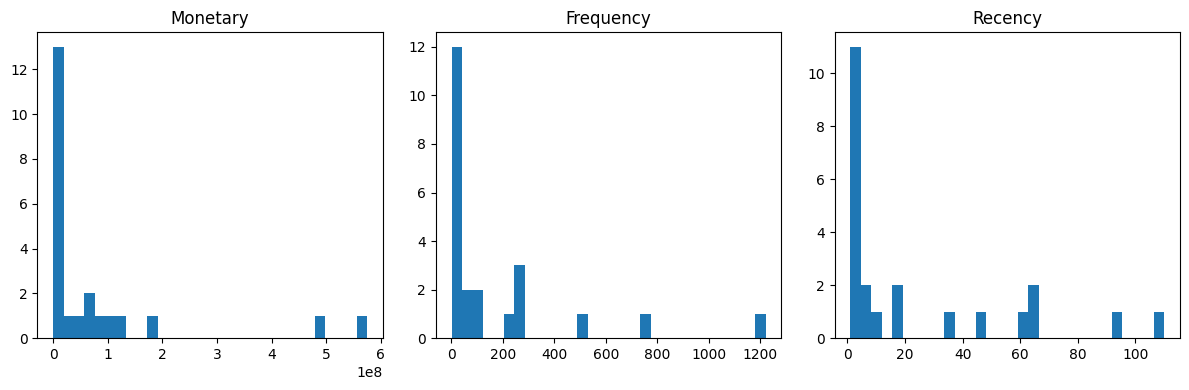

In [37]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(customer['Monetary'], bins=30)
plt.title("Monetary")

plt.subplot(1,3,2)
plt.hist(customer['Frequency'], bins=30)
plt.title("Frequency")

plt.subplot(1,3,3)
plt.hist(customer['Recency'], bins=30)
plt.title("Recency")

plt.tight_layout()
plt.show()


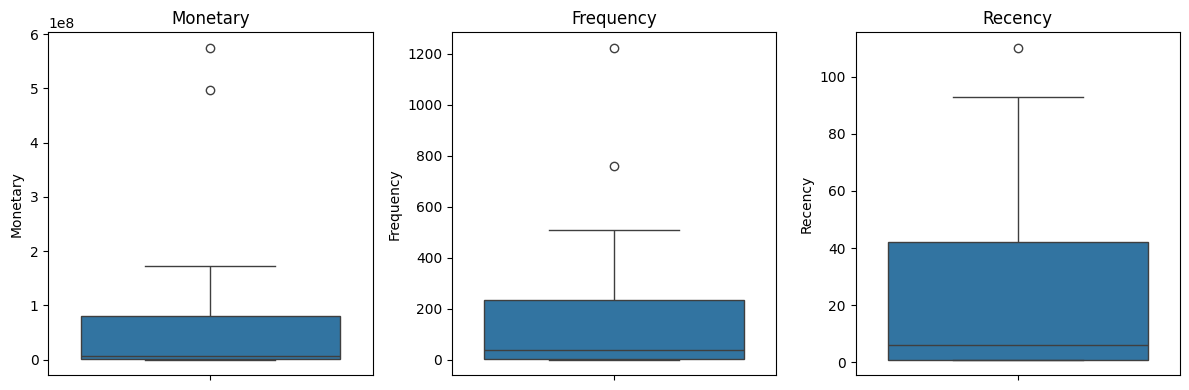

In [38]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.boxplot(y=customer['Monetary'])
plt.title("Monetary")

plt.subplot(1,3,2)
sns.boxplot(y=customer['Frequency'])
plt.title("Frequency")

plt.subplot(1,3,3)
sns.boxplot(y=customer['Recency'])
plt.title("Recency")

plt.tight_layout()
plt.show()


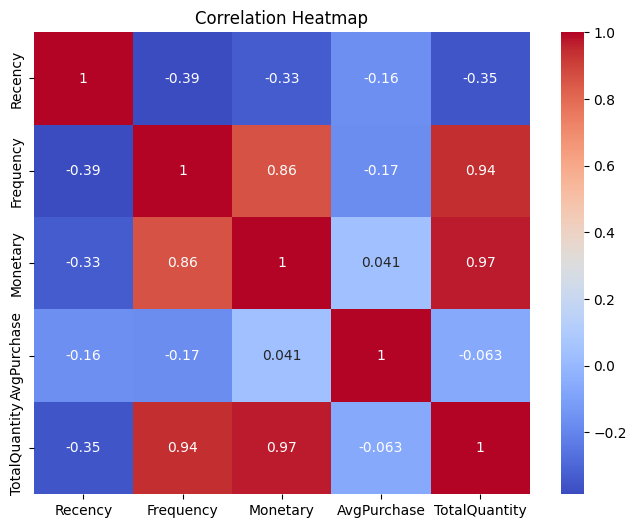

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(
    customer[['Recency','Frequency','Monetary','AvgPurchase','TotalQuantity']].corr(),
    annot=True, cmap='coolwarm'
)
plt.title("Correlation Heatmap")
plt.show()


In [40]:
customer['LoyaltyIndex'] = customer['Frequency'] * customer['AvgPurchase']
customer['RecencyScore'] = 1 / (1 + customer['Recency'])
customer['ValueTier'] = pd.qcut(customer['Monetary'], 3, labels=['Low','Medium','High'])

# Engagement Score
customer['TotalQuantity_norm'] = MinMaxScaler().fit_transform(
    customer[['TotalQuantity']]
)
customer['EngagementScore'] = customer['TotalQuantity_norm'] * customer['Frequency_norm']

customer[['Customer','LoyaltyIndex','RecencyScore','ValueTier','EngagementScore']].head()


,Customer,LoyaltyIndex,RecencyScore,ValueTier,EngagementScore
0,De Majok,1.926868e+07,0.009009,Medium,0.000803
1,Deeski Store Limited,1.197739e+08,0.333333,High,0.118038
2,Ecopeaks Limited,8.612433e+07,0.250000,High,0.044222
3,Ekulo International Limited(Wine world),9.491500e+03,0.083333,Low,0.000000
4,Extreme Manufacturing Nigeria limited,8.459000e+04,0.027027,Low,0.000004


In [41]:
features = [
    'RecencyScore','Frequency_norm','Monetary_norm',
    'LoyaltyIndex','EngagementScore'
]

X = customer[features].copy()

# Log-transform skewed features
X['LoyaltyIndex'] = np.log1p(X['LoyaltyIndex'])
X['EngagementScore'] = np.log1p(X['EngagementScore'])

# Standardize
scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(X)


In [42]:
inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))


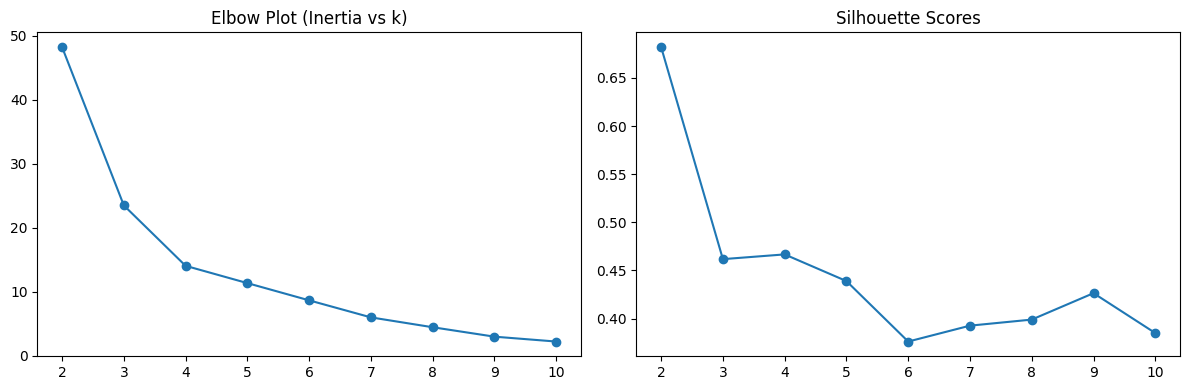

In [43]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.title("Elbow Plot (Inertia vs k)")

plt.subplot(1,2,2)
plt.plot(K, silhouettes, marker='o')
plt.title("Silhouette Scores")

plt.tight_layout()
plt.show()


In [ ]:
best_k = K[np.argmax(silhouettes)]
best_k


kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
customer['Cluster'] = kmeans.fit_predict(X_scaled)
customer.head()


,Customer,Recency,Frequency,Monetary,AvgPurchase,TotalQuantity,Monetary_norm,Frequency_norm,TopRegion,Region_Lagos,Region_Ogun,LoyaltyIndex,RecencyScore,ValueTier,TotalQuantity_norm,EngagementScore,Cluster
0,De Majok,110,37,1.926868e+07,520775.135135,1887,0.033519,0.029484,Lagos,True,False,1.926868e+07,0.009009,Medium,0.027243,0.000803,0
1,Deeski Store Limited,2,508,1.197739e+08,235775.480591,19681,0.208355,0.415233,Lagos,True,False,1.197739e+08,0.333333,High,0.284270,0.118038,0
2,Ecopeaks Limited,3,255,8.612433e+07,337742.472157,14718,0.149819,0.208026,Lagos,True,False,8.612433e+07,0.250000,High,0.212581,0.044222,0
3,Ekulo International Limited(Wine world),11,1,9.491500e+03,9491.500000,1,0.000016,0.000000,Lagos,True,False,9.491500e+03,0.083333,Low,0.000000,0.000000,0
4,Extreme Manufacturing Nigeria limited,36,10,8.459000e+04,8459.000000,37,0.000147,0.007371,Lagos,True,False,8.459000e+04,0.027027,Low,0.000520,0.000004,0


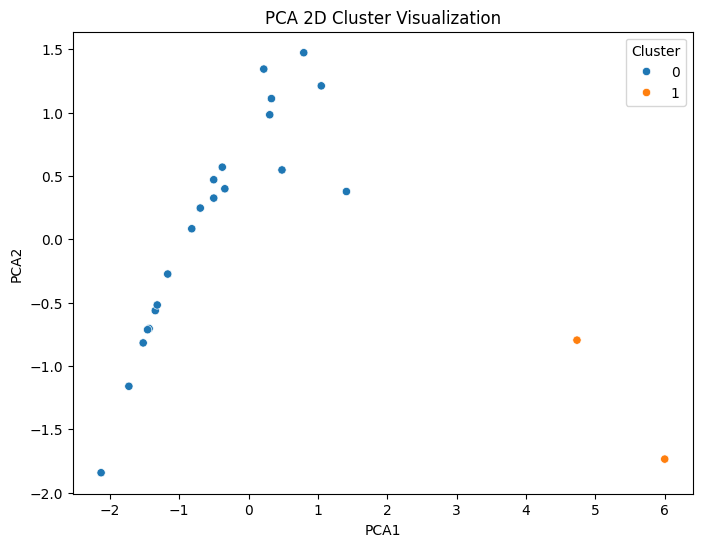

In [46]:
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(X_scaled)

customer['PCA1'] = pca_vals[:,0]
customer['PCA2'] = pca_vals[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer, palette='tab10')
plt.title("PCA 2D Cluster Visualization")
plt.show()


In [47]:
cluster_summary = customer.groupby('Cluster').agg({
    'Customer':'count',
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'LoyaltyIndex':'mean',
    'EngagementScore':'mean'
})

cluster_summary


,Customer,Recency,Frequency,Monetary,LoyaltyIndex,EngagementScore
Cluster,,,,,,
0,21,26.285714,92.714286,3.385829e+07,3.385829e+07,0.011835
1,2,1.000000,990.500000,5.360106e+08,5.360106e+08,0.776998


In [48]:
customer.to_csv('customer_segments2.csv', index=False)
print("Saved to /mnt/data/customer_segments.csv")


Saved to /mnt/data/customer_segments.csv
